In [64]:
import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import mne
from mne import Epochs, pick_types, find_events
from mne.filter import filter_data
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_gdf
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from EEGModels import EEGNet
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# %matplotlib tk


'''
Parameters:
'''
tmin = -.1
tmax = 2

In [65]:
object_names = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10']
# object_names = ['P07']
runMove = [3, 4, 5, 6, 7, 10, 11, 12, 13]
files = []
for name in object_names:
    for i in runMove:
        files.append(read_raw_gdf(f'..\\{name}\\{name} Run {i}.gdf', stim_channel=None, eog=[61,62,63], preload=True))

Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75519  =      0.000 ...   294.996 secs...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creatin

C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

In [66]:
print(len(files))

90


In [67]:
eventDescription_offline_paradigm = {
    #'768': "trial start",
    #'785': "beep",
    #'786': "fixation cross",
    '776': "supinationclass cue",
    '777': "pronationclass cue",
    '779': "hand openclass cue",
    '925': "palmar graspclass cue",
    '926': "ateral graspclass cue",
}
# narrow it down to two
eventDescription_offline_paradigm = {
   '779': "hand openclass cue",
   '925': "palmar graspclass cue",
}

In [68]:
# events = [number of events, position, event code, channel, duration]
# file_P01_Run3._raw_extras[0]['events']
event_id = {}
epochs_list = []
for file in files:
    # band pass filter
    file.filter(0, 15, method='fir')
    event, _ = mne.events_from_annotations(file)
    # build event id and filter 1-7 id

    contains_both = 0
    for i in _: #handle event_id
        if i not in eventDescription_offline_paradigm:
            continue
        contains_both += 1
        event_id[eventDescription_offline_paradigm[i]] = _[i]


    print(f'event id: {event_id}')
    if contains_both == len(eventDescription_offline_paradigm):
        epochs = mne.Epochs(file, event, event_id, tmin=tmin, tmax=tmax, baseline=None, event_repeated = 'merge', preload=True)
        epochs_list.append(epochs)

result_epochs = mne.concatenate_epochs(epochs_list)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 227 samples (0.887 sec)

Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'hand openclass cue': 11, 'palmar graspclass cue': 14}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 539 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 15 Hz

FIR filter parameters
-------------------

Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
[[ 4921     0    11]
 [22479     0    11]
 [43603     0    11]
 [48658     0    11]
 [50450     0    11]
 [54233     0    11]
 [56175     0    11]
 [71533     0    11]]
[[12348     0    14]
 [14235     0    14]
 [27539     0    14]
 [34798     0    14]
 [38215     0    14]
 [57730     0    14]
 [59516     0    14]
 [67881     0    14]]
Effective window size : 8.000 (s)


<ipython-input-69-f94208927d6a>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  file.plot_psd(fmax=30)


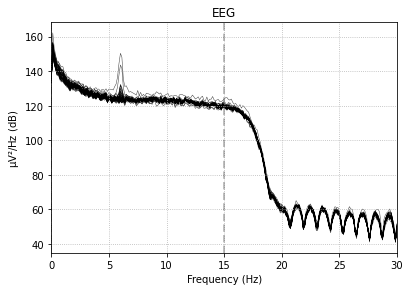

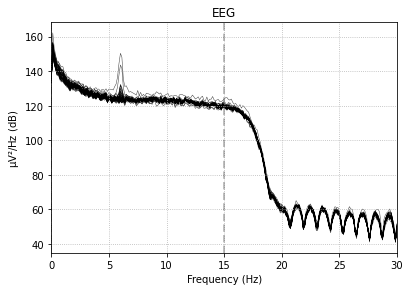

In [69]:
# plotting
file = files[0]
event, _ = mne.events_from_annotations(file)
event1 = np.array(list(filter(lambda x: x[2] == 11, event)))
event2 = np.array(list(filter(lambda x: x[2] == 14, event)))
print(event1)
print(event2)
file.plot_psd(fmax=30)

In [70]:
print(len(set(event_id)))
#9, 10, 0
print(result_epochs.events)

2
[[   4921       0      11]
 [  12348       0      14]
 [  14235       0      14]
 ...
 [6591115       0      14]
 [6596574       0      11]
 [6598556       0      14]]


In [71]:
# 0: not supinationclass or pronationclass cue
labels = result_epochs.events[:,-1]
# labels = np.array(list(map(lambda x:  0 if (not x == 9) else x, labels)))
print(labels)

# format: trials, channels, samples
X = result_epochs.get_data()
y = labels

kernels, chans, samples = 1, X.shape[1], X.shape[2]

[11 14 14 ... 14 11 14]


In [72]:
print(np.argmax(result_epochs.get_data()[0]))
print(np.argmax(result_epochs.get_data()[1]))
print(np.argmax(result_epochs.get_data()[2]))



12419
14607
15630


In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(Y_train)

[14 11 11 ... 14 14 11]


In [74]:
# Label Encode it first
encoder = OneHotEncoder()
encoder.fit([[x] for x in Y_train])
Y_train = encoder.transform([[x] for x in Y_train]).toarray()
Y_test = encoder.transform([[x] for x in Y_test]).toarray()

# Convert label to one-hot encodings
# Y_train = np_utils.to_categorical(Y_train)
# Y_validate = np_utils.to_categorical(Y_validate)
# Y_test = np_utils.to_categorical(Y_test)

#convert to (trials, kernels, channels, samples) format.
# contains 64 channels and 257 time-points. Set the number of kernels to 1.
X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1008, 1, 64, 539)
1008 train samples
432 test samples


In [75]:
print(Y_train)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [76]:
# testing gpu
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
for physical_device in gpus:
    tf.config.experimental.set_memory_growth(physical_device, True)
# change the memory fraction as you want...import tensorflow as tf
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)
print(gpus)

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [81]:
classes_num = len(eventDescription_offline_paradigm)
# configure the EEGNet-8,2,16 model with kernel length of 257 samples (other
# model configurations may do better, but this is a good starting point)
# class num is one
model = EEGNet(nb_classes = classes_num, Chans = chans, Samples = samples,
               dropoutRate = 0.8, kernLength = 128, F1 = 8, D = 2, F2 = 16)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 64, 539)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 64, 539)        1024      
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 64, 539)        32        
_________________________________________________________________
depthwise_conv2d_4 (Depthwis (None, 16, 1, 539)        1024      
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 1, 539)        64        
_________________________________________________________________
activation_8 (Activation)    (None, 16, 1, 539)        0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 16, 1, 134)       

In [82]:
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='.\\checkpoint.h5', verbose=1,
                               save_best_only=True)


In [83]:
# add callback
losses = []
accs = []
class LossAndAccRecord(Callback):
    def on_batch_end(self, batch, logs=None):
        losses.append(logs["loss"])
        accs.append(logs["accuracy"])


    def on_epoch_end(self, epoch, logs=None):
        pass


In [84]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# unused
class_weights = {0:1, 1:1, 2:1, 3:1}
with tf.device('/device:GPU:0'):
    fittedModel = model.fit(X_train, Y_train, batch_size = 20, epochs = 60,
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/60
51/51 [==============================] - 55s 1s/step - loss: 0.7318 - accuracy: 0.4950
Epoch 2/60
51/51 [==============================] - 57s 1s/step - loss: 0.7258 - accuracy: 0.4950
Epoch 3/60
51/51 [==============================] - 58s 1s/step - loss: 0.7072 - accuracy: 0.5476
Epoch 4/60
51/51 [==============================] - 61s 1s/step - loss: 0.7074 - accuracy: 0.5169
Epoch 5/60
51/51 [==============================] - 62s 1s/step - loss: 0.7068 - accuracy: 0.5427
Epoch 6/60
51/51 [==============================] - 60s 1s/step - loss: 0.7034 - accuracy: 0.5327
Epoch 7/60
51/51 [==============================] - 62s 1s/step - loss: 0.7097 - accuracy: 0.5317
Epoch 8/60
51/51 [==============================] - 63s 1s/step - loss: 0.7027 - accuracy: 0.5367
Epoch 9/60
51/51 [==============================] - 56s 1s/step - loss: 0.7094 - accuracy: 0.5050
Epoch 10/60
51/51 [==============================] - 57s 1s/step - loss: 0.7119 - accuracy: 0.5278
Epoch 11/60
51/51 [

KeyboardInterrupt: 

In [ ]:
# load optimal weights
# model.load_weights('./checkpoint.h5')

In [ ]:
###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
print(probs)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %.4f " % (acc))

In [ ]:
confusion_matrix(Y_test.argmax(axis=-1), preds)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(accs)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()